In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder import Autoencoder
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from autoencoder import reduce_dimensions
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster

# Data Preprocessing

In [30]:
# Predefined stuff

n_epochs = 5
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [32]:
# training and testing data as dataloaders

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [34]:
train_loader_pca = copy.copy(train_loader)
test_loader_pca = copy.copy(test_loader)

train_loader_auto = copy.copy(train_loader)
test_loader_auto = copy.copy(test_loader)

In [36]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# PCA

In [38]:
train_data = []
train_labels = []
for data, labels in train_loader_pca:
    train_data.append(data.view(data.size(0), -1))  
    train_labels.append(labels)
train_data = torch.cat(train_data, dim=0)  
train_labels = torch.cat(train_labels, dim=0)

train_data_np = train_data.numpy()

pca = PCADigitReducer(100)
train_data_reduced = pca.fit_transform(train_data_np)  

train_data_reconstructed_np = pca.inverse_transform(train_data_reduced) 
train_data_reconstructed = torch.tensor(train_data_reconstructed_np, dtype=torch.float32)

train_data_reconstructed = train_data_reconstructed.view(-1, 1, 28, 28)

train_data_reconstructed = (train_data_reconstructed - 0.1307) / 0.3081

batch_size_train = train_loader_pca.batch_size
train_dataset_pca = CustomTensorDataset(train_data_reconstructed, train_labels)
train_loader_reduced_pca = DataLoader(train_dataset_pca, batch_size=batch_size_train, shuffle=True)

# Autoencoder

In [39]:
latent_dim = 100  
autoencoder = Autoencoder(latent_dim=latent_dim)
auto_criterion = nn.MSELoss()
auto_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
auto_num_epochs = 5
for epoch in range(auto_num_epochs): 
    for images, _ in train_loader_auto:
        auto_optimizer.zero_grad()
        reconstructed = autoencoder(images)
        loss = auto_criterion(reconstructed, images)  
        loss.backward()
        auto_optimizer.step()
        
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item()}")

Epoch [1/5], Loss: 0.5662664175033569
Epoch [2/5], Loss: 0.5423806309700012
Epoch [3/5], Loss: 0.5064288377761841
Epoch [4/5], Loss: 0.5391950607299805
Epoch [5/5], Loss: 0.5142180323600769


In [40]:
autoencoder.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_features, labels = reduce_dimensions(train_loader_auto, autoencoder.encoder, device)
latent_features = latent_features.detach()

reconstructed_images = autoencoder.decoder(latent_features.to(device))  
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)

# Experiment

In [ ]:
# cluster: 6, CLient: 10

In [44]:
alpha_values = [0.1, 0.5, 1, 5, 10, 20]
num_clients = 10
num_clusters = 6
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic

In [46]:
# classic
trainingset = train_loader.dataset
trial_model = classification_model()
global_model_classic = classification_model()
rounds_classic = 4

In [50]:
for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")

    # Classic
    partitioned_data_classic = partition.balanced_dirichlet_partition(
        trainingset, partitions_number=num_clients, alpha=alpha
    )

    classic_client_loaders = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic.values()
    ]


    local_models_classic = [copy.deepcopy(global_model_classic) for _ in range(num_clients)]

    optimizer = optim.SGD(trial_model.parameters(), lr=learning_rate, momentum=momentum)

    train_losses = []
    train_counter = []

    for epoch in range(1, n_epochs + 1):
        train(epoch, trial_model, train_loader, optimizer, log_interval, train_losses, train_counter)

    test_losses_classic_weak = []
    test(trial_model, test_loader, test_losses_classic_weak)

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic):
            print(f"Training client {client_idx + 1}")

            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)

            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)

        global_weights_classic = federated_averaging(local_weights_classic)

        distribute_global_model(global_weights_classic, local_models_classic, single=False)
        distribute_global_model(global_weights_classic, global_model_classic, single=True)

        test_losses = []
        test(global_model_classic, test_loader, test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for non-clustered classic
        if alpha not in results["classic"]:
            results["classic"][alpha] = {"losses": [], "accuracy": []}

        results["classic"][alpha]["losses"].extend(test_losses)
        results["classic"][alpha]["accuracy"].extend(test_accuracies_classic)

    ######################
    import cluster

    cluster = cluster.Cluster(num_clusters=num_clusters)

    targets = trainingset.targets
    num_classes = len(set(targets))
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)

    partitioned_data_classic_clustered = clustered_data

    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic[0: num_clusters]):
            print(f"Training client {client_idx + 1}")

            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, classic_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)

            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)

        global_weights_classic = federated_averaging(local_weights_classic)

        distribute_global_model(global_weights_classic, local_models_classic, single=False)
        distribute_global_model(global_weights_classic, global_model_classic, single=True)

        test_losses = []
        test(global_model_classic, test_loader, test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for clustered classic
        if alpha not in clusteredResults["classic"]:
            clusteredResults["classic"][alpha] = {"losses": [], "accuracy": []}

        clusteredResults["classic"][alpha]["losses"].extend(test_losses)
        clusteredResults["classic"][alpha]["accuracy"].extend(test_accuracies_classic)

Running experiment with alpha: 0.1 


C:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.373595
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.305434
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.275401
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.236221
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.229350
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.255284
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.156510
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.163547
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.094289
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.931286
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.849544
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.680981
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.765529
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.637998
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.575528
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1.372618
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.366193
Train Epoch: 1 [17000/60000 (28%)]	Loss: 1.338472
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.362826
Train Epoch: 1 [19000/60000 (32%)]	Loss: 1.224796
Train Epoch: 1 [200

C:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0953, Accuracy: 9712/10000 (97%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 2.324710
Train Epoch: 1 [1000/11393 (9%)]	Loss: 2.191483
Train Epoch: 1 [2000/11393 (18%)]	Loss: 1.973357
Train Epoch: 1 [3000/11393 (26%)]	Loss: 1.847816
Train Epoch: 1 [4000/11393 (35%)]	Loss: 1.618418
Train Epoch: 1 [5000/11393 (44%)]	Loss: 1.548867
Train Epoch: 1 [6000/11393 (53%)]	Loss: 1.281930
Train Epoch: 1 [7000/11393 (61%)]	Loss: 1.199922
Train Epoch: 1 [8000/11393 (70%)]	Loss: 1.073549
Train Epoch: 1 [9000/11393 (79%)]	Loss: 1.171237
Train Epoch: 1 [10000/11393 (88%)]	Loss: 1.073372
Train Epoch: 1 [11000/11393 (96%)]	Loss: 0.725879
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.992219
Train Epoch: 2 [1000/11393 (9%)]	Loss: 0.934313
Train Epoch: 2 [2000/11393 (18%)]	Loss: 0.700909
Train Epoch: 2 [3000/11393 (26%)]	Loss: 0.661711
Train Epoch: 2 [4000/11393 (35%)]	Loss: 0.840695
Train Epoch: 2 [5000/11393 (44%)]	Loss: 0.652955
Train Epoch: 2 [6000/11393 (53%)]	Loss: 

In [51]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {0.1: {'losses': [1.6319534790039063, 0.7516739562988282, 0.4554614318847656, 0.3289968292236328], 'accuracy': [54.21, 81.85, 87.93, 90.81]}, 0.5: {'losses': [0.10599350357055665, 0.09780720977783203, 0.09121249694824218, 0.08703732070922851], 'accuracy': [96.78, 96.95, 97.07, 97.23]}, 1: {'losses': [0.06176316642761231, 0.05986271133422852, 0.05853633346557617, 0.05637010765075683], 'accuracy': [97.97, 98.14, 98.16, 98.26]}, 5: {'losses': [0.048927339172363284, 0.047304075622558596, 0.046763033294677736, 0.04578540725708008], 'accuracy': [98.53, 98.6, 98.61, 98.64]}, 10: {'losses': [0.04171942691802979, 0.04051288375854492, 0.039765463638305666, 0.03993171272277832], 'accuracy': [98.67, 98.73, 98.75, 98.74]}, 20: {'losses': [0.03696223678588867, 0.03705424194335938, 0.03626164112091065, 0.03654940700531006], 'accuracy': [98.86, 98.9, 98.9, 98.91]}}, 'pca': {}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {0.1: {'losses': [0.24525

# PCA

In [52]:
# PCA
trainingset_pca = train_loader_reduced_pca.dataset
trial_model_pca = classification_model()
global_model_pca = classification_model() 

In [53]:
for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")

    partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=alpha)

    pca_client_loaders = [
        DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_pca.values()
    ]

    local_models_pca = [copy.deepcopy(global_model_pca) for _ in range(num_clients)]

    optimizer = optim.SGD(trial_model_pca.parameters(), lr=learning_rate, momentum=momentum)

    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):  
        train(epoch, trial_model_pca, train_loader_reduced_pca, optimizer, log_interval, train_losses, train_counter)
 
    test_losses_classic_pca = []
    test(trial_model_pca, train_loader_reduced_pca, test_losses_classic_pca)

    rounds_pca = 4
    
    for round_idx in range(rounds_pca):
        print(f"Round {round_idx + 1}/{rounds_pca}")
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
        global_weights_pca = federated_averaging(local_weights_pca)

        distribute_global_model(global_weights_pca, local_models_pca, single=False)
        distribute_global_model(global_weights_pca, global_model_pca, single=True)

        test_losses = []
        test(global_model_pca, test_loader_pca, test_losses)
        
        test_accuracies_pca = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_pca:
                output = global_model_pca(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_pca.append(accuracy)

        # Save results for each partitions_number
        if alpha not in results["pca"]:
            results["pca"][alpha] = {"losses": [], "accuracy": []}

        results["pca"][alpha]["losses"].extend(test_losses)
        results["pca"][alpha]["accuracy"].extend(test_accuracies_pca)

    ######################
    import cluster

    cluster = cluster.Cluster(num_clusters=num_clusters)
    targets = trainingset_pca.targets
    num_classes = len(set(targets))
    clustered_data = cluster.apply_clustering(partitioned_data_pca, targets, num_classes)

    partitioned_data_pca_clustered = clustered_data
    pca_client_loaders_clustered = [
        DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_pca_clustered.values()
    ]
    
    for round_idx in range(rounds_pca):
        print(f"Round {round_idx + 1}/{rounds_pca}")
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca[0:num_clusters]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, pca_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
        global_weights_pca = federated_averaging(local_weights_pca)

        distribute_global_model(global_weights_pca, local_models_pca, single=False)
        distribute_global_model(global_weights_pca, global_model_pca, single=True)

        test_losses = []
        test(global_model_pca, test_loader_pca, test_losses)
        
        test_accuracies_pca = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_pca:
                output = global_model_pca(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_pca.append(accuracy)

        # Save clustered results for each partitions_number
        if alpha not in clusteredResults["pca"]:
            clusteredResults["pca"][alpha] = {"losses": [], "accuracy": []}

        clusteredResults["pca"][alpha]["losses"].extend(test_losses)
        clusteredResults["pca"][alpha]["accuracy"].extend(test_accuracies_pca)

Running experiment with alpha: 0.1 
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.511854
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.229377
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.155821
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.100969
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.968736
Train Epoch: 1 [5000/60000 (8%)]	Loss: 1.698571
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.631691
Train Epoch: 1 [7000/60000 (12%)]	Loss: 1.510803
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.354865
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.381921
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.017304
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.017386
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.892970
Train Epoch: 1 [13000/60000 (22%)]	Loss: 0.932662
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.007201
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.803146
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.795573
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.864436
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.918393
Train Epoch: 1 [19000/60000 (32%)

In [54]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {0.1: {'losses': [1.6319534790039063, 0.7516739562988282, 0.4554614318847656, 0.3289968292236328], 'accuracy': [54.21, 81.85, 87.93, 90.81]}, 0.5: {'losses': [0.10599350357055665, 0.09780720977783203, 0.09121249694824218, 0.08703732070922851], 'accuracy': [96.78, 96.95, 97.07, 97.23]}, 1: {'losses': [0.06176316642761231, 0.05986271133422852, 0.05853633346557617, 0.05637010765075683], 'accuracy': [97.97, 98.14, 98.16, 98.26]}, 5: {'losses': [0.048927339172363284, 0.047304075622558596, 0.046763033294677736, 0.04578540725708008], 'accuracy': [98.53, 98.6, 98.61, 98.64]}, 10: {'losses': [0.04171942691802979, 0.04051288375854492, 0.039765463638305666, 0.03993171272277832], 'accuracy': [98.67, 98.73, 98.75, 98.74]}, 20: {'losses': [0.03696223678588867, 0.03705424194335938, 0.03626164112091065, 0.03654940700531006], 'accuracy': [98.86, 98.9, 98.9, 98.91]}}, 'pca': {0.1: {'losses': [1.9848115356445313, 1.3638842895507812, 1.0023270935058595, 0.8008578

# Autoencoder

In [55]:
# Autoencoder
trainingset_auto = reduced_train_loader_auto.dataset
trial_model_auto = classification_model()
global_model_auto = classification_model()

In [56]:
for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")
    
    partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=alpha)

    auto_client_loaders = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto.values()
    ]

    local_model_autoencoder = [copy.deepcopy(global_model_auto) for _ in range(num_clients)]

    optimizer = optim.SGD(trial_model_auto.parameters(), lr=learning_rate, momentum=momentum)

    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):  
        train(epoch, trial_model_auto, reduced_train_loader_auto, optimizer, log_interval, train_losses, train_counter)
 
    test_losses_classic_auto = []
    test(trial_model_auto, reduced_train_loader_auto, test_losses_classic_auto)
    
    rounds_auto = 4
    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
    
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
            
        global_weights_auto = federated_averaging(local_weights_auto)
    
        distribute_global_model(global_weights_auto, local_model_autoencoder, single=False)
        distribute_global_model(global_weights_auto, global_model_auto, single=True)

        test_losses = []
        test(global_model_auto, test_loader_auto, test_losses)
        
        test_accuracies_auto = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                output = global_model_auto(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_auto.append(accuracy)

        # Save results for each partitions_number
        if alpha not in results["autoencoder"]:
            results["autoencoder"][alpha] = {"losses": [], "accuracy": []}

        results["autoencoder"][alpha]["losses"].extend(test_losses)
        results["autoencoder"][alpha]["accuracy"].extend(test_accuracies_auto)

    ######################
    import cluster
    cluster = cluster.Cluster(num_clusters=num_clusters)
    
    targets = trainingset_auto.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_auto, targets, num_classes)
    partitioned_data_auto_clustered = clustered_data

    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]

    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")

        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder[0:num_clusters]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, auto_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
            
        global_weights_auto = federated_averaging(local_weights_auto)

        distribute_global_model(global_weights_auto, local_model_autoencoder, single=False)
        distribute_global_model(global_weights_auto, global_model_auto, single=True)

        test_losses = []
        test(global_model_auto, test_loader_auto, test_losses)
        
        test_accuracies_auto = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                output = global_model_auto(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_auto.append(accuracy)

        # Save clustered results for each partitions_number
        if alpha not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][alpha] = {"losses": [], "accuracy": []}

        clusteredResults["autoencoder"][alpha]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][alpha]["accuracy"].extend(test_accuracies_auto)


Running experiment with alpha: 0.1 
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313138
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.310026
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.310916
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.309601
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.300685
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.304747
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.283776
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.313986
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.291572
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.301630
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.299696
Train Epoch: 1 [11000/60000 (18%)]	Loss: 2.289004
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.293365
Train Epoch: 1 [13000/60000 (22%)]	Loss: 2.296614
Train Epoch: 1 [14000/60000 (23%)]	Loss: 2.289825
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.288892
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.283169
Train Epoch: 1 [17000/60000 (28%)]	Loss: 2.271082
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.286966
Train Epoch: 1 [19000/60000 (32%)

In [57]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {0.1: {'losses': [1.6319534790039063, 0.7516739562988282, 0.4554614318847656, 0.3289968292236328], 'accuracy': [54.21, 81.85, 87.93, 90.81]}, 0.5: {'losses': [0.10599350357055665, 0.09780720977783203, 0.09121249694824218, 0.08703732070922851], 'accuracy': [96.78, 96.95, 97.07, 97.23]}, 1: {'losses': [0.06176316642761231, 0.05986271133422852, 0.05853633346557617, 0.05637010765075683], 'accuracy': [97.97, 98.14, 98.16, 98.26]}, 5: {'losses': [0.048927339172363284, 0.047304075622558596, 0.046763033294677736, 0.04578540725708008], 'accuracy': [98.53, 98.6, 98.61, 98.64]}, 10: {'losses': [0.04171942691802979, 0.04051288375854492, 0.039765463638305666, 0.03993171272277832], 'accuracy': [98.67, 98.73, 98.75, 98.74]}, 20: {'losses': [0.03696223678588867, 0.03705424194335938, 0.03626164112091065, 0.03654940700531006], 'accuracy': [98.86, 98.9, 98.9, 98.91]}}, 'pca': {0.1: {'losses': [1.9848115356445313, 1.3638842895507812, 1.0023270935058595, 0.8008578

# Plot


Non-Clustered Results:
classic:
  Average Loss: {0.1: 0.7920214241027832, 0.5: 0.09551263275146485, 1: 0.05913307971954346, 5: 0.04719496383666992, 10: 0.04048237175941467, 20: 0.03670688171386719}
  Average Accuracy: {0.1: 78.7, 0.5: 97.00750000000001, 1: 98.1325, 5: 98.595, 10: 98.7225, 20: 98.89249999999998}
pca:
  Average Loss: {0.1: 1.2879701919555664, 0.5: 0.3189213928222656, 1: 0.19379517326354984, 5: 0.15376627540588378, 10: 0.13149382514953611, 20: 0.11405654945373535}
  Average Accuracy: {0.1: 82.5725, 0.5: 97.8575, 1: 98.5425, 5: 98.75999999999999, 10: 98.8475, 20: 98.9375}
autoencoder:
  Average Loss: {0.1: 1.0222941482543946, 0.5: 0.2304058853149414, 1: 0.15657538146972655, 5: 0.1387371503829956, 10: 0.12131041927337646, 20: 0.11015204515457154}
  Average Accuracy: {0.1: 66.49499999999999, 0.5: 94.8875, 1: 96.82750000000001, 5: 97.32499999999999, 10: 97.6675, 20: 97.9025}


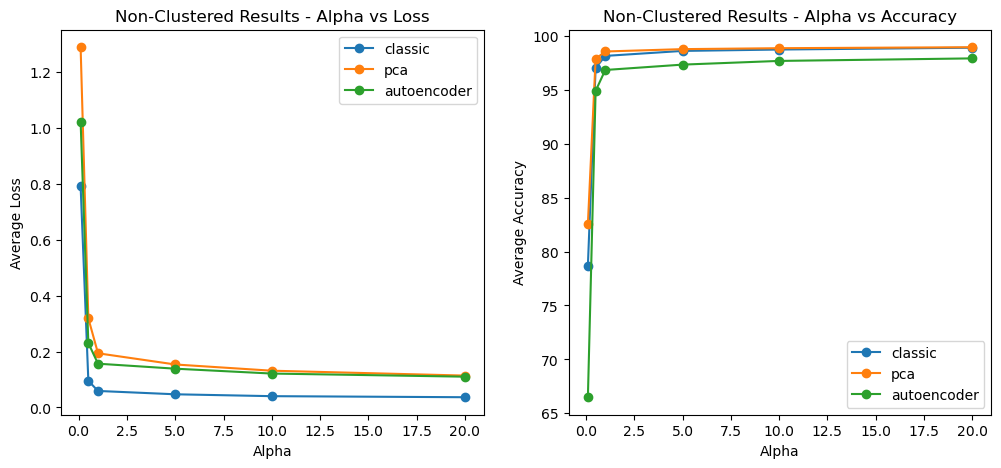


Clustered Results:
classic:
  Average Loss: {0.1: 0.18146381282806395, 0.5: 0.0717859203338623, 1: 0.051739701414108275, 5: 0.044363854598999025, 10: 0.038382955646514894, 20: 0.035685123014450065}
  Average Accuracy: {0.1: 94.68, 0.5: 97.64250000000001, 1: 98.37, 5: 98.62249999999999, 10: 98.83, 20: 98.915}
pca:
  Average Loss: {0.1: 0.5221160652160645, 0.5: 0.2365109519958496, 1: 0.17419830474853515, 5: 0.14556291847229005, 10: 0.1243785566329956, 20: 0.11292763500213623}
  Average Accuracy: {0.1: 96.2225, 0.5: 98.235, 1: 98.695, 5: 98.7475, 10: 98.9075, 20: 98.89}
autoencoder:
  Average Loss: {0.1: 0.40499098587036136, 0.5: 0.18346645030975342, 1: 0.14358580932617188, 5: 0.1262544885635376, 10: 0.11706847553253175, 20: 0.10840844540596009}
  Average Accuracy: {0.1: 90.0975, 0.5: 96.235, 1: 97.125, 5: 97.53, 10: 97.75999999999999, 20: 97.9425}


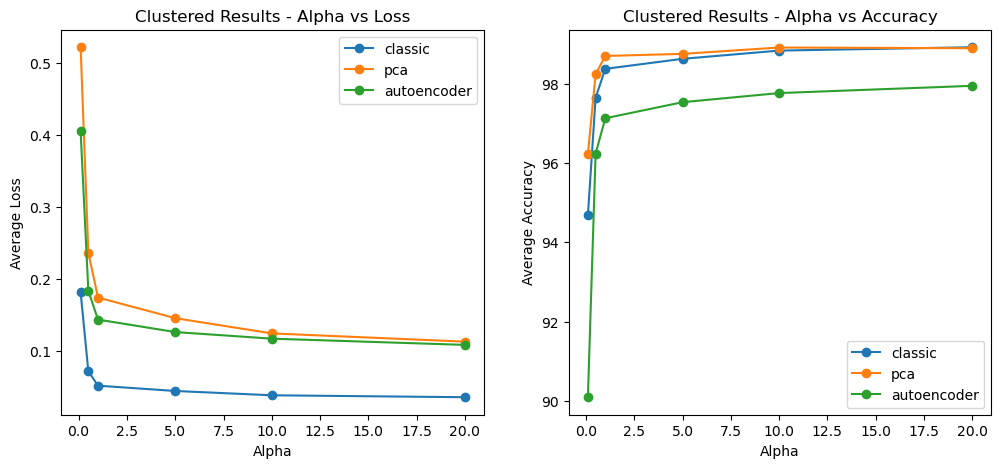

In [71]:
import numpy as np
import matplotlib.pyplot as plt

def compute_avg(metrics):
    avg_loss = {alpha: np.mean(data['losses']) for alpha, data in metrics.items()}
    avg_accuracy = {alpha: np.mean(data['accuracy']) for alpha, data in metrics.items()}
    return avg_loss, avg_accuracy

def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        avg_loss, avg_accuracy = compute_avg(results[method])
        print(f"{method}:")
        print("  Average Loss:", avg_loss)
        print("  Average Accuracy:", avg_accuracy)

def plot_results(results, title, filename):
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    for method in results.keys():
        avg_loss, _ = compute_avg(results[method])
        plt.plot(avg_loss.keys(), avg_loss.values(), marker='o', label=method)
    plt.xlabel('Alpha')
    plt.ylabel('Average Loss')
    plt.title(f'{title} - Alpha vs Loss')
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    for method in results.keys():
        _, avg_accuracy = compute_avg(results[method])
        plt.plot(avg_accuracy.keys(), avg_accuracy.values(), marker='o', label=method)
    plt.xlabel('Alpha')
    plt.ylabel('Average Accuracy')
    plt.title(f'{title} - Alpha vs Accuracy')
    plt.legend()
    
    plt.savefig(filename)
    plt.show()


print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")
print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")
